In [63]:
%pip install tensorflow_io

Note: you may need to restart the kernel to use updated packages.


In [64]:
import os
import matplotlib.pyplot as plt
from pathlib import Path
import tensorflow as tf
import tensorflow_io as tfio
import IPython.display as ipd
import numpy as np

In [65]:
def load_audio(file_path):
    audio_binary = tf.io.read_file(file_path)
    audio, sample_rate = tf.audio.decode_wav(audio_binary)
    waveform = tf.squeeze(audio, axis=-1)
    return waveform, sample_rate

def load_audio_files(path: str, label:str):

    dataset = []
    walker = sorted(str(p) for p in Path(path).glob(f'*.wav'))

    for i, file_path in enumerate(walker):
        path, filename = os.path.split(file_path)
        speaker, _ = os.path.splitext(filename)
        speaker_id, utterance_number = speaker.split("_nohash_")
        utterance_number = int(utterance_number)

        # Load audio
        waveform, sample_rate = load_audio(file_path)
        dataset.append([waveform, sample_rate, label, speaker_id, utterance_number])

    return dataset

In [66]:
trainset_speechcommands_yes = load_audio_files('../data/mini_speech_commands/yes', 'yes')
trainset_speechcommands_no = load_audio_files('../data/mini_speech_commands/no', 'no')

print(f'Length of yes dataset: {len(trainset_speechcommands_yes)}')
print(f'Length of no dataset: {len(trainset_speechcommands_no)}')

Length of yes dataset: 1000
Length of no dataset: 1000


In [67]:
yes_waveform = trainset_speechcommands_yes[0][0]
yes_sample_rate = trainset_speechcommands_yes[0][1]
print(f'Yes Waveform: {yes_waveform}')
print(f'Yes Sample Rate: {yes_sample_rate}')
print(f'Yes Label: {trainset_speechcommands_yes[0][2]}')
print(f'Yes ID: {trainset_speechcommands_yes[0][3]}')

no_waveform = trainset_speechcommands_no[0][0]
no_sample_rate = trainset_speechcommands_no[0][1]
print(f'No Waveform: {no_waveform}')
print(f'No Sample Rate: {no_sample_rate}')
print(f'No Label: {trainset_speechcommands_no[0][2]}')
print(f'No ID: {trainset_speechcommands_no[0][3]}')

Yes Waveform: [-0.0027771  -0.00537109 -0.00338745 ... -0.00112915 -0.00131226
 -0.00140381]
Yes Sample Rate: 16000
Yes Label: yes
Yes ID: 004ae714
No Waveform: [0.00720215 0.00610352 0.00552368 ... 0.00979614 0.0085144  0.00921631]
No Sample Rate: 16000
No Label: no
No ID: 012c8314


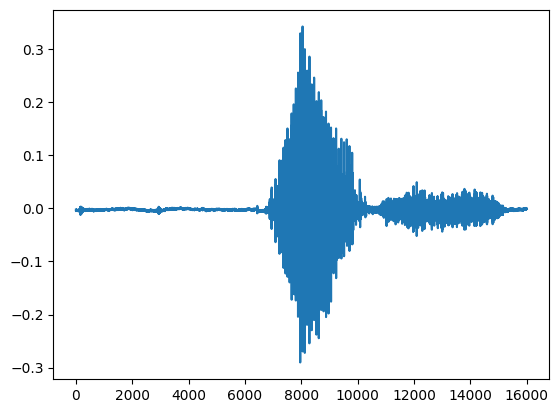

In [68]:
timescale = np.arange(yes_waveform.shape[0])
plt.figsize=(12, 8)
plt.plot(timescale, yes_waveform.numpy())
plt.show()

In [69]:
def get_spectrogram(waveform):

    frame_length = 255
    frame_step = 128
    # Padding for files with less than 16000 samples
    zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

    # Concatenate audio with padding so that all audio clips will be of the same length
    waveform = tf.cast(waveform, tf.float32)
    equal_length_waveform = tf.concat([waveform, zero_padding], 0)

    # Option 1: Use tfio to get the spectrogram
    spect = tfio.audio.spectrogram(input=equal_length_waveform, nfft=frame_length, window=frame_length, stride=frame_step)

    # Option 2: Use tf.signal processing to get the Short-time Fourier transform (stft)
    spectrogram = tf.signal.stft(equal_length_waveform, frame_length=frame_length, frame_step=frame_step)
    spectrogram = tf.abs(spectrogram)

    return spectrogram, spect

## This funciton has some code from https://www.tensorflow.org/tutorials/audio/simple_audio

In [70]:
spectrogram, spect = get_spectrogram(yes_waveform)

print('Label:', 'yes')
print('Waveform shape:', yes_waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Spect shape:', spect.shape)
print('Audio playback')
ipd.Audio(yes_waveform.numpy(), rate=16000)

Label: yes
Waveform shape: (16000,)
Spectrogram shape: (124, 129)
Spect shape: (125, 128)
Audio playback


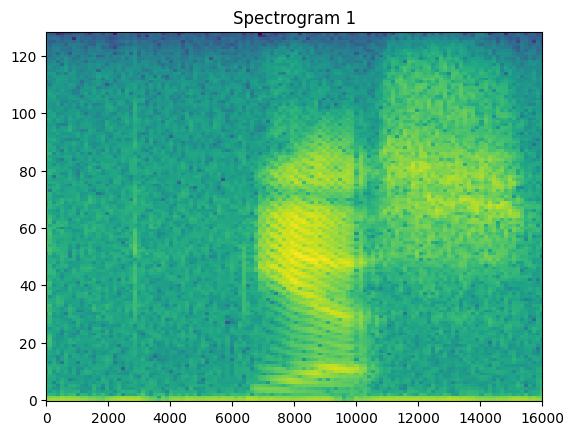

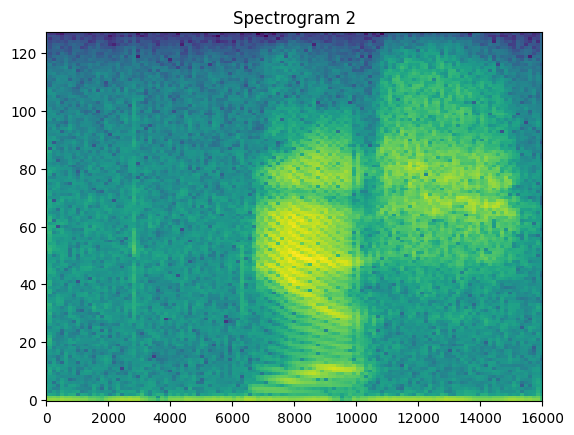

In [71]:
def plot_spectrogram(spectrogram, ax, title):
    # Convert to frequencies to log scale and transpose so that the time is
    # represented in the x-axis (columns).
    log_spec = np.log(spectrogram.T)
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
    Y = range(height)
    ax.pcolormesh(X, Y, log_spec)
    ax.set_xlim([0, 16000])
    ax.set_title(title)

fig, ax = plt.subplots()
plot_spectrogram(spectrogram.numpy(), ax, 'Spectrogram 1')
plt.show()

fig, ax = plt.subplots()
plot_spectrogram(spect.numpy(), ax, 'Spectrogram 2')
plt.show()

In [72]:
def create_images(dataset, label_dir):
    # make directory
    test_directory = f'./data/test/{label_dir}/'
    train_directory = f'./data/train/{label_dir}/'

    os.makedirs(test_directory, mode=0o777, exist_ok=True)
    os.makedirs(train_directory, mode=0o777, exist_ok=True)

    for i, data in enumerate(dataset):

        waveform = data[0]
        spectrogram, spect = get_spectrogram(waveform)

        # Split test and train images by 30%
        if i % 3 == 0:
            plt.imsave(f'./data/test/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')
        else:
            plt.imsave(f'./data/train/{label_dir}/spec_img{i}.png', spectrogram.numpy(), cmap='gray')

In [73]:
create_images(trainset_speechcommands_yes, 'yes')
create_images(trainset_speechcommands_no, 'no')